# Title: Assignment 2: Credit Card Fraud Detection

# Author: "10194574"

## Introduction:
In assignment 2, you will get familier with Jupyter Notebook and Python for predictive data analytics task. Jupyter notebook is very similar to Rmarkdown,it is Python veriosn of Rmarkdown

To start with, you should install Jupyter Notenook on your laptop/PC. The easist way for beginners is to install Jupyter Notebook via Anaconda https://www.anaconda.com/distribution/. You can also install Jupyter Notebook from Python. A nice tutorial on Jupyter Notebook installation and usage: https://www.dataquest.io/blog/jupyter-notebook-tutorial/. Introduction to the history of Jupyter Notebook: https://www.youtube.com/watch?v=ctOM-Gza04Y

Your goal in this assignment is to compare multiple machine learning classifiers, namely Logistic Regression (covered in topic 1), Random Forest (typical bagging method), XGBoost on a popular predictive data analystics task, i.e., Credit Card Fraud Detection. You will also be asked to perform hyperparameter tuning for three classifiers using random search and grid search. 

You can always add more code/markdown cells.

## Dataset
The dataset we are using is from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv. The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
# import needed Python libraries, e.g., sklearn and xgboost 
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_score, f1_score, recall_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Task 1: load dataset and set up pipeline (10 points).
In reality, we usually use 10-fold cross validation rather than reporting evalution performance on one single split of data. Cross-validation: Ref. https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79 

Using pandas to load and explore data, e.g., dataset = pd.read_csv(r"D:/Datasets/creditfraud.csv", sep=';'). 
Ref: https://www.datacamp.com/community/tutorials/pandas-read-csv

pandas is similar to dataframe in R. You can also use dataset.head(3) to check the initial 3 rows of your dataset.

Using scikit-learn package, you can easily build data analytics pipeline.
e.g., 
``` 
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn import datasets  # import build-in dataset
from sklearn import svm  # import model

iris = datasets.load_iris()  # load dataset
clf_svc_cv = svm.SVC(kernel='linear',C=1)  # build a support vector machine with parameters
scores_clf_svc_cv = cross_val_score(clf_svc_cv,iris.data,iris.target,cv=10)  # 10-fold cross validation
print(scores_clf_svc_cv) # print results
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_clf_svc_cv.mean(), scores_clf_svc_cv.std() * 2))  # print accuracy
 ```

https://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html

You can also use sklearn.model_selection.StratifiedKFold, so that you could iterate 10 folds and perform data preprocessing.
e.g., 

``` 
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
cv = StratifiedKFold(n_splits=10)

for train_idx, test_idx, in cv.split(X, y):
   sm = SMOTE()
   X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
   model = ...  # Choose a model here
   model.fit(X_train_oversampled, y_train_oversampled ) 
   y_pred = model.predict(X_test)
   print(f'For fold {fold}:')
   print(f'Accuracy: {model.score(X_test, y_test)}')
   print(f'f-score: {f1_score(y_test, y_pred)}') 
 ```


In [7]:
df = pd.read_csv("creditcard.csv")
print(df.head(4))
print(df.shape)
X = df.drop(['Class'], axis=1)
y = df['Class']

number_splits=10
cv = StratifiedKFold(n_splits=number_splits)
print(y.unique()) # outputs the classes to be predicted: 0, 1

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0

## Task 2: model building and evaluation (40 points). 
Create three models: Logistic Regression, Random Forest, Gradient Boost (XGBoost) using their default hyperparameter values. Report the default parameter values and model performance in terms of precision, recall, F-measure, and AUC. Note that you should perform evalution under the cross validation framework. 

Note that Fraud is your positive class. You don't need to consider all hyperparameters provided by the tool, only focusing on three or four important ones. 

We will apply SMOTE technique to deal with the highly imbalanced dataset. Ref. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
E.g.,  
```
sm = SMOTE()
X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
```

How to build random forest and xgboost model? 
E.g.,
```
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)

import xgboost as xgb
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, Y_train)
Y_pred = gbm.predict(X_test)
```




TRAIN: [ 11710  11841  11880 ... 284804 284805 284806] TEST: [    0     1     2 ... 28522 28523 28524]
__________________________________________________________
For fold: 1
Accuracy: 0.8848
f1 score: 0.4836
recall score: 0.9321
precision score: 0.5072
AUC score: 0.9945
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [11710 11841 11880 ... 57018 57019 57020]
__________________________________________________________
For fold: 2
Accuracy: 0.9527
f1 score: 0.5211
recall score: 0.9661
precision score: 0.5172
AUC score: 0.9942
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [30442 30473 30496 ... 85497 85498 85499]


c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


__________________________________________________________
For fold: 3
Accuracy: 0.9790
f1 score: 0.5651
recall score: 0.9895
precision score: 0.5379
AUC score: 0.9996
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 48094  50211  50537 ... 113966 113967 113968]
__________________________________________________________
For fold: 4
Accuracy: 0.9855
f1 score: 0.5777
recall score: 0.9011
precision score: 0.5450
AUC score: 0.9653
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 80760  81186  81609 ... 142427 142428 142429]


c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


__________________________________________________________
For fold: 5
Accuracy: 0.9862
f1 score: 0.5813
recall score: 0.9014
precision score: 0.5471
AUC score: 0.9698
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [119714 119781 120505 ... 170948 170949 170950]
__________________________________________________________
For fold: 6
Accuracy: 0.9800
f1 score: 0.5619
recall score: 0.9301
precision score: 0.5361
AUC score: 0.9665
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150647 150654 150660 ... 199403 199404 199405]


c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


__________________________________________________________
For fold: 7
Accuracy: 0.9794
f1 score: 0.5651
recall score: 0.9697
precision score: 0.5379
AUC score: 0.9877
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [154697 154718 154719 ... 227867 227868 227869]


c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


__________________________________________________________
For fold: 8
Accuracy: 0.9856
f1 score: 0.5795
recall score: 0.9113
precision score: 0.5460
AUC score: 0.9915
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [212516 212644 213092 ... 256351 256352 256353]
__________________________________________________________
For fold: 9
Accuracy: 0.9933
f1 score: 0.6566
recall score: 0.9457
precision score: 0.5960
AUC score: 0.9882
TRAIN: [     0      1      2 ... 256351 256352 256353] TEST: [243749 243848 244004 ... 284804 284805 284806]


c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


__________________________________________________________
For fold: 10
Accuracy: 0.9981
f1 score: 0.7941
recall score: 0.8870
precision score: 0.7373
AUC score: 0.9828
log_total_accuracy: 0.9725
log_total_f1: 0.5886
log_total_recall: 0.9334
log_total_precision: 0.5608
log_total_auc: 0.984


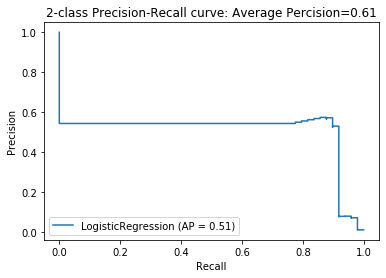

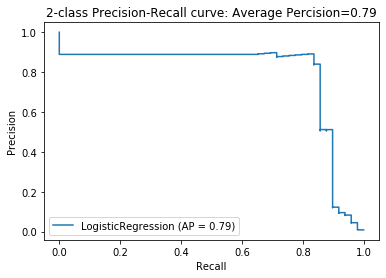

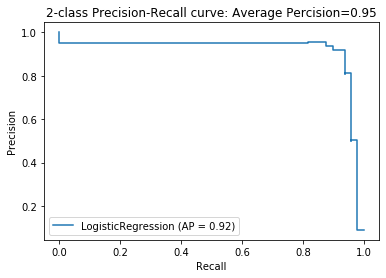

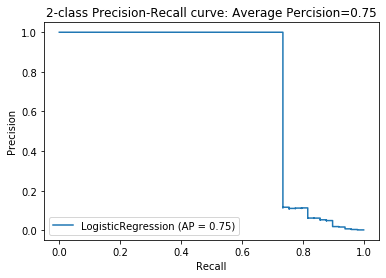

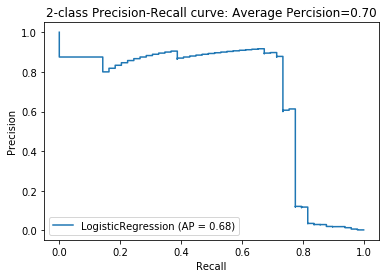

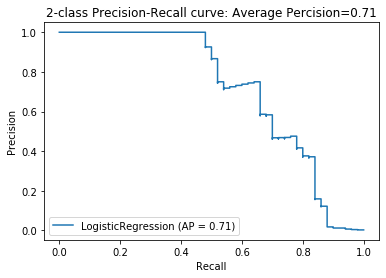

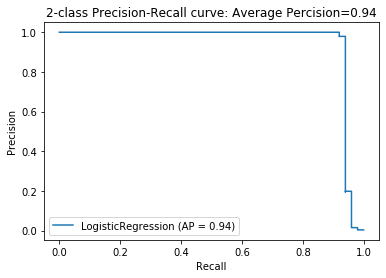

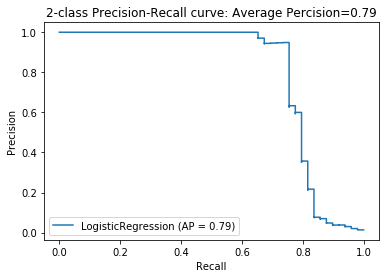

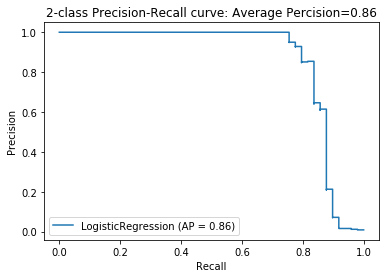

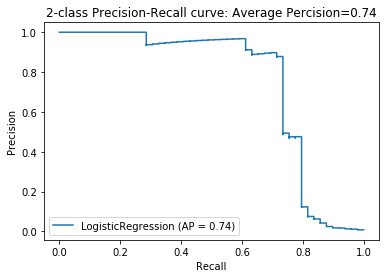

In [7]:
# Logistic Regression:
i=1
log_total_accuracy=0
log_total_f1=0
log_total_precision=0
log_total_recall=0
log_total_auc=0
for train_index, test_index, in cv.split(X, y):
    sm = SMOTE()
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = LogisticRegression()  # Choose a model
    model.fit(X_train_oversampled, y_train_oversampled )
    y_score= model.decision_function(X_test)
    y_pred = model.predict(X_test)
    
    # Compute results.
    accuracy=model.score(X_test, y_test)
    f1=f1_score(y_test, y_pred, average="macro")
    recall=recall_score(y_test, y_pred, average="macro")
    precision=precision_score(y_test, y_pred, average="macro")
    auc=roc_auc_score(y_test, y_score)
    average_precision=average_precision_score(y_test, y_score)
    
    # Show results. 
    print('__________________________________________________________')
    print('For fold:', i)
    print('Accuracy: {0:0.4f}'.format(accuracy))
    print("f1 score: {0:0.4f}".format(f1))
    print("recall score: {0:0.4f}".format(recall))
    print("precision score: {0:0.4f}".format(precision))
    print('AUC score: {0:0.4f}'.format(auc))
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Percision={0:0.2f}'.format(average_precision))
    
    # Update logic for filling in average values for table. 
    log_total_accuracy+=accuracy
    log_total_f1+=f1
    log_total_recall+=recall
    log_total_precision+=precision
    log_total_auc+=auc
    i+=1
    

print("log_total_accuracy:", round(log_total_accuracy/number_splits, 4))
print("log_total_f1:", round(log_total_f1/number_splits, 4))
print("log_total_recall:", round(log_total_recall/number_splits, 4))
print("log_total_precision:", round(log_total_precision/number_splits, 4))
print("log_total_auc:", round(log_total_auc/number_splits, 4))

TRAIN: [ 11710  11841  11880 ... 284804 284805 284806] TEST: [    0     1     2 ... 28522 28523 28524]
__________________________________________________________
For fold: 1
Accuracy: 0.9731
f1 score: 0.5446
recall score: 0.9356
precision score: 0.5272
AUC score: 0.9742
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [11710 11841 11880 ... 57018 57019 57020]
__________________________________________________________
For fold: 2
Accuracy: 0.9990
f1 score: 0.8064
recall score: 0.7346
precision score: 0.9419
AUC score: 0.9488
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [30442 30473 30496 ... 85497 85498 85499]
__________________________________________________________
For fold: 3
Accuracy: 0.9998
f1 score: 0.9699
recall score: 0.9795
precision score: 0.9607
AUC score: 0.9999
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 48094  50211  50537 ... 113966 113967 113968]
__________________________________________________________
For fold: 4
Accurac

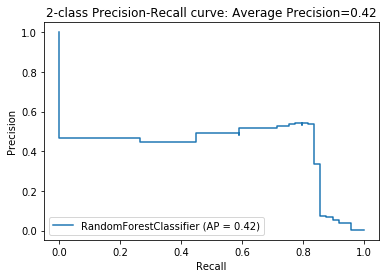

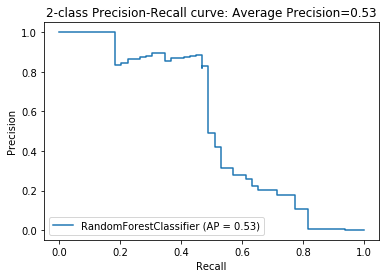

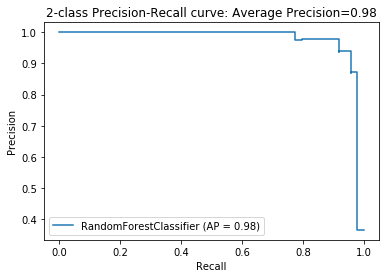

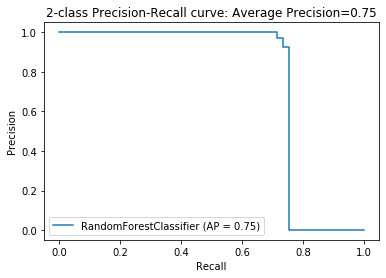

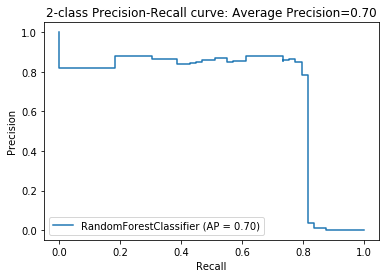

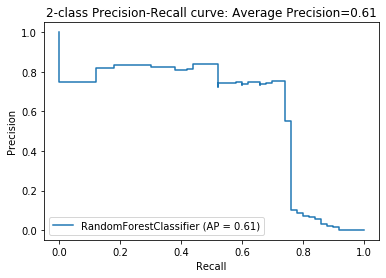

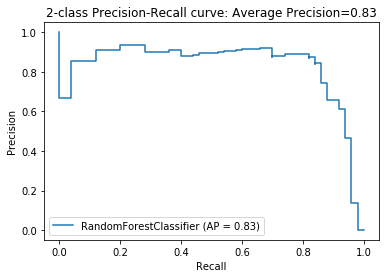

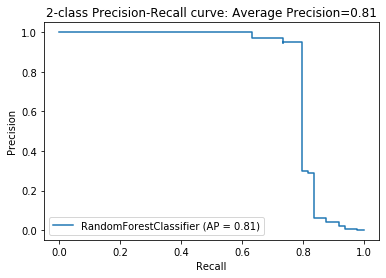

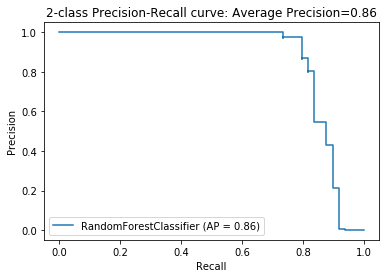

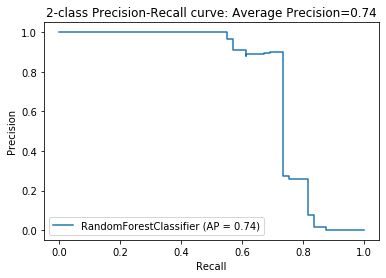

In [8]:
# Random Forest:
i=1
rf_total_accuracy=0
rf_total_f1=0
rf_total_precision=0
rf_total_recall=0
rf_total_auc=0
for train_index, test_index, in cv.split(X, y):
    sm = SMOTE()
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = RandomForestClassifier(oob_score=True)  # Choose a model
    model.fit(X_train_oversampled, y_train_oversampled ) 
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba = y_pred_proba[:,1]
    
    # Compute results.
    accuracy=model.score(X_test, y_test)
    f1=f1_score(y_test, y_pred, average="macro")
    recall=recall_score(y_test, y_pred, average="macro")
    precision=precision_score(y_test, y_pred, average="macro")
    auc=roc_auc_score(y_test, y_pred_proba)
    average_precision=average_precision_score(y_test, y_pred_proba)

    # Show results. 
    print('__________________________________________________________')
    print('For fold:', i)
    print('Accuracy: {0:0.4f}'.format(accuracy))
    print("f1 score: {0:0.4f}".format(f1))
    print("recall score: {0:0.4f}".format(recall))
    print("precision score: {0:0.4f}".format(precision))
    print('AUC score: {0:0.4f}'.format(auc))
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision))
    
    # Update logic for filling in average values for table. 
    rf_total_accuracy+=accuracy
    rf_total_f1+=f1
    rf_total_recall+=recall
    rf_total_precision+=precision
    rf_total_auc+=auc
    i+=1
    

print("rf_total_accuracy:", round(rf_total_accuracy/number_splits, 4))
print("rf_total_f1:", round(rf_total_f1/number_splits, 4))
print("rf_total_recall:", round(rf_total_recall/number_splits, 4))
print("rf_total_precision:", round(rf_total_precision/number_splits, 4))
print("rf_total_auc:", round(rf_total_auc/number_splits, 4))

TRAIN: [ 11710  11841  11880 ... 284804 284805 284806] TEST: [    0     1     2 ... 28522 28523 28524]
__________________________________________________________
For fold: 1
Accuracy: 0.9816
f1 score: 0.5726
recall score: 0.9806
precision score: 0.5419
AUC score: 0.9928
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [11710 11841 11880 ... 57018 57019 57020]
__________________________________________________________
For fold: 2
Accuracy: 0.9780
f1 score: 0.5608
recall score: 0.9788
precision score: 0.5356
AUC score: 0.9830
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [30442 30473 30496 ... 85497 85498 85499]
__________________________________________________________
For fold: 3
Accuracy: 0.9773
f1 score: 0.5601
recall score: 0.9886
precision score: 0.5353
AUC score: 0.9997
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 48094  50211  50537 ... 113966 113967 113968]
__________________________________________________________
For fold: 4
Accurac

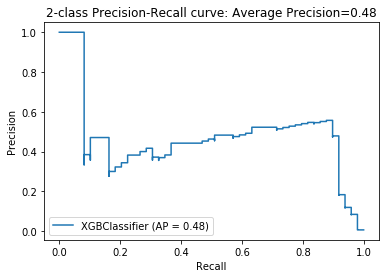

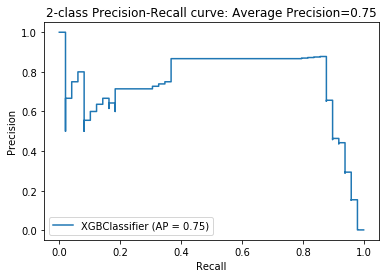

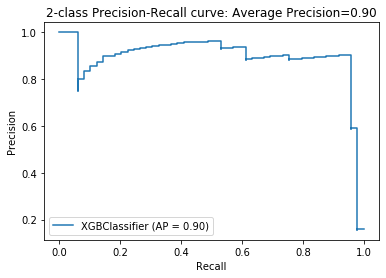

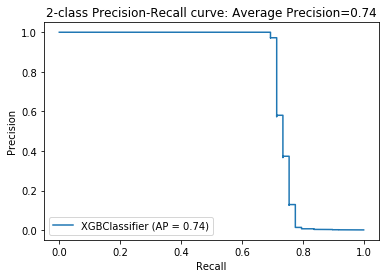

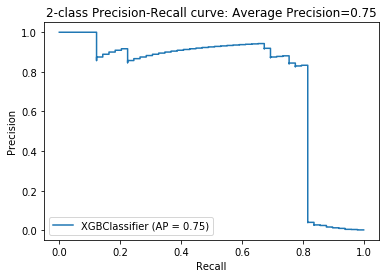

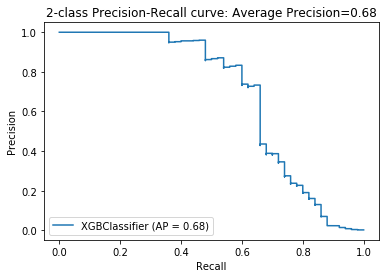

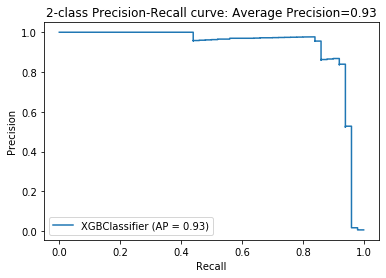

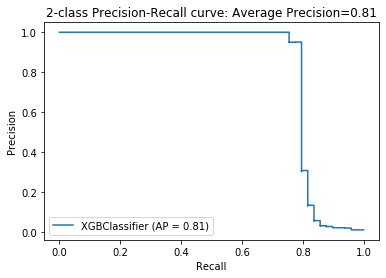

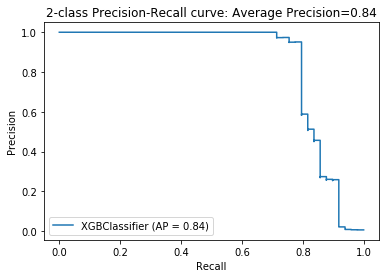

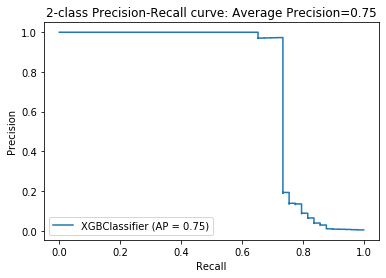

In [9]:
# XGBoost:
i=1
xgb_total_accuracy=0
xgb_total_f1=0
xgb_total_precision=0
xgb_total_recall=0
xgb_total_auc=0
for train_index, test_index, in cv.split(X, y):
    sm = SMOTE()
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    model = xgb.XGBClassifier()  # Choose a model
    model.fit(X_train_oversampled, y_train_oversampled) 
    y_pred = model.predict(X_test)
    y_score= model.predict_proba(X_test)[:,1]
    
    # Compute results.
    accuracy=model.score(X_test, y_test)
    f1=f1_score(y_test, y_pred, average="macro")
    recall=recall_score(y_test, y_pred, average="macro")
    precision=precision_score(y_test, y_pred, average="macro")
    auc=roc_auc_score(y_test, y_score)
    average_precision=average_precision_score(y_test, y_score)
    
    # Show results. 
    print('__________________________________________________________')
    print('For fold:', i)
    print('Accuracy: {0:0.4f}'.format(accuracy))
    print("f1 score: {0:0.4f}".format(f1))
    print("recall score: {0:0.4f}".format(recall))
    print("precision score: {0:0.4f}".format(precision))
    print('AUC score: {0:0.4f}'.format(auc))
    disp = plot_precision_recall_curve(model, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision))
    
    # Update logic for filling in average values for table. 
    xgb_total_accuracy+=accuracy
    xgb_total_f1+=f1
    xgb_total_recall+=recall
    xgb_total_precision+=precision
    xgb_total_auc+=auc
    i+=1
    

print("xgb_total_accuracy:", round(xgb_total_accuracy/number_splits, 4))
print("xgb_total_f1:", round(xgb_total_f1/number_splits, 4))
print("xgb_total_recall:", round(xgb_total_recall/number_splits, 4))
print("xgb_total_precision:", round(xgb_total_precision/number_splits, 4))
print("xgb_total_auc:", round(xgb_total_auc/number_splits, 4))

In [ ]:
# # Ignore this part, was used to create even folds, 
# but StratifiedKFold was a better random selection method. 

# # # index testing
# # i=28480
# # X_train_temp1 = X.iloc[0:i, :]
# # X_train_temp2 = X.iloc[int((len(X.index)/10)+i): ,:]
# # X_train_temp1.append(X_train_temp2)

# a=0
# i=0
# while (a < 10):
#     X_val = X.iloc[i:int((len(X.index)/10)+i),:]
#     X_train_temp1 = X.iloc[0:i, :]
#     X_train_temp2 = X.iloc[int((len(X.index)/10)+i): ,:]
#     X_train_temp1.append(X_train_temp2) # X_train_temp1 now contains both sets
    
#     i+= int(len(X.index)/10)
#     print("X_val: ___________________________________________________________")
#     print(X_val)
#     print("X_train_temp1: ++++++++++++++++++++++++++++++++++++++++++++++++++++++")
#     print(X_train_temp1)
#     a+=1
#     print("a: %2f" % a)


Answer: Please fill the following table based on your experiment results:

| Classifier | Default Hyperparameter values | Precision | Recall | AUC | Accuracy
| --- | --- | --- | --- | --- | --- |
| Logistic Regression | penalty='l2', l1_ratio=None, tol=0.0001, max_iter=100 | 0.5608 | 0.9334 | 0.9840 | 0.9725 |
| Random Forest | n_estimators=100, criterion='gini', max_features='auto' | 0.8976 | 0.8847 | 0.9425 | 0.9968 |
| XGBoost | max_depth=3, learning_rate=0.1, n_estimators=100, scale_pos_weight=1 | 0.5770 | 0.9361 | 0.9708 | 0.9879 |

The Default Hyperparameter values are the ones chosen to tune in the following Task 3. 

## Task 3:  hyperparameter tuning (40 points).
For each classifier, turn the hyperparameter using random search and grid search. Report the best performance for each classifier and their running time.
Ref. https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html


In [9]:
import numpy as np
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [6]:
# Logistic Regression
model=LogisticRegression()
# specify parameters and distributions to sample from
param_dist = {'tol' : loguniform (1e-5, 1e-3),
              'max_iter' : stats.uniform (50,150),
              'l1_ratio' : stats.uniform (0,1)}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS

RandomizedSearchCV took 564.89 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.997 (std: 0.004)
Parameters: {'l1_ratio': 0.8339703173880608, 'max_iter': 69.39852491874689, 'tol': 0.00034361756980779264}

Model with rank: 2
Mean validation score: 0.997 (std: 0.004)
Parameters: {'l1_ratio': 0.42499817501489257, 'max_iter': 72.59060723037861, 'tol': 0.0002234472501145007}

Model with rank: 3
Mean validation score: 0.997 (std: 0.005)
Parameters: {'l1_ratio': 0.6656201868127672, 'max_iter': 103.75571885234399, 'tol': 1.3434638257296884e-05}



c:\users\r-k-l\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [4]:
# Random Forest
model=RandomForestClassifier()
# specify parameters and distributions to sample from
param_dist = {'n_estimators' : [80,90,100,110,120],
              'criterion' : ['gini', 'entropy'],
              'max_features' : ['auto','log2'],
             }

# run randomized search
n_iter_search = 5
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 3571.33 seconds for 5 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.999 (std: 0.001)
Parameters: {'n_estimators': 110, 'max_features': 'log2', 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.994 (std: 0.012)
Parameters: {'n_estimators': 120, 'max_features': 'log2', 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.911 (std: 0.176)
Parameters: {'n_estimators': 80, 'max_features': 'auto', 'criterion': 'entropy'}



In [8]:
# from xgboost import xgb
# XGBoost
import numpy as np
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
model=xgb.XGBClassifier()
# specify parameters and distributions to sample from
param_dist = {'learning_rate' : [0.05, 0.1, 0.15],
              'n_estimators' : [80,100,120],
              'scale_pos_weight' : stats.uniform (0.75,1.25),
              'max_depth ' : [2,3,4]
             }

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 2747.10 seconds for 10 candidates parameter settings.


NameError: name 'report' is not defined

In [10]:
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.993 (std: 0.013)
Parameters: {'learning_rate': 0.1, 'max_depth ': 2, 'n_estimators': 80, 'scale_pos_weight': 0.7508759962571072}

Model with rank: 2
Mean validation score: 0.958 (std: 0.083)
Parameters: {'learning_rate': 0.15, 'max_depth ': 4, 'n_estimators': 80, 'scale_pos_weight': 1.8422135290498272}

Model with rank: 3
Mean validation score: 0.957 (std: 0.084)
Parameters: {'learning_rate': 0.1, 'max_depth ': 2, 'n_estimators': 120, 'scale_pos_weight': 1.346054686175197}



Answer: Please list your best performance model, hyper parameter values for the best model and running time below:


| Classifier | Hyperparameter values | Runtime | Models | Accuracy |
| --- | --- | --- | --- | --- |
| Logistic Regression | l1_ratio=0.8339703173880608, tol=0.0.00034361756980779264, max_iter=69.39852491874689 | 564.89s | 20 | 0.997 (std: 0.004) |
| Random Forest | n_estimators=110, criterion='entropy', max_features='log2' | 3571.33s | 5 | 0.999 (std: 0.001) |
| XGBoost | max_depth=2, learning_rate=0.1, n_estimators=80, scale_pos_weight=0.7508759962571072 | 2747.10s | 10 | 0.993 (std: 0.013) |

## Task 4:  take-away message (10 points)
Please summary your findings from the above analysis (at least 2 findings):

-The accuracies of all models seems impressive, however since the binary classification was heavily skewed in the favour of class 0 with only ~500 cases of class 1 in a ~29,000 sample dataset. 

-The Random Forest models for both the un-changed and changed hyper parameters had the overall best accuracy. It also had the best precision, and not the best recall/AUC. This is a good indication of predictions having a high f1 score, meaning the balance between recall and precision is good. However, this came at the expense of the longest runtime of the three models, nearly 3 times as long as XGBoost. 

-The other models (LR, XGB) performed very well on recall and AUC, meaning that the true positive rate was very high. However, the precision rates were low and in turn giving a low f1 (recall-precision balance) score. Models with low precision may be better for non-overfitting models, but can mis-identify certain class cases via overgeneralizing. 